# Experiment-5: Decision Trees from Scratch
**Date:** October 8, 2025

## Objective
In this assignment, we will implement a Decision Tree Classifier from scratch using NumPy and apply it to the Adult Income Dataset. The task is to predict whether a person earns more than $50K per year. We will build the tree, evaluate it, and perform both pre-pruning and post-pruning.

## Dataset
- **Source:** Adult Income Dataset from UCI
- **Task:** Binary classification (≤ 50K vs. > 50K)
- **Features:** Mix of categorical (workclass, education, occupation) and numeric (age, hours-per-week)
- **Target:** Income

## 1. Install and Import Required Libraries

In [1]:
# Install required packages
!pip install ucimlrepo

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

  Using cached ucimlrepo-0.0.7-py3-none-any.whl.metadata (5.5 kB)
Using cached ucimlrepo-0.0.7-py3-none-any.whl (8.0 kB)
Libraries imported successfully!


## 2. Load and Explore the Adult Dataset

In [3]:
# Load the Adult Income Dataset
adult = fetch_ucirepo(id=2)
X = adult.data.features  # features (pandas DataFrame)
y = adult.data.targets   # target (pandas DataFrame)

print("Dataset loaded successfully!")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print("\n" + "="*50)

# Display basic information about the dataset
print("Dataset Information:")
print(adult.metadata)
print("\n" + "="*50)

print("Variable Information:")
print(adult.variables)
print("\n" + "="*50)

print("Feature columns:")
print(X.columns.tolist())
print("\nTarget column:")
print(y.columns.tolist())
print("\nFirst few rows of features:")
print(X.head())
print("\nFirst few rows of target:")
print(y.head())

Dataset loaded successfully!
Features shape: (48842, 14)
Target shape: (48842, 1)

Dataset Information:
{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Ba

## 3. Data Preprocessing and Cleaning

In [4]:
# Check for missing values in features
print("Missing values in features:")
print(X.isnull().sum())
print("\nMissing values in target:")
print(y.isnull().sum())

# Check for '?' values (which are often used as missing values in this dataset)
print("\nChecking for '?' values in categorical columns:")
for col in X.select_dtypes(include=['object']).columns:
    question_count = (X[col] == '?').sum()
    if question_count > 0:
        print(f"{col}: {question_count} '?' values")

# Data types
print("\nData types:")
print(X.dtypes)
print(f"\nTarget data type: {y.dtypes}")

# Basic statistics for numerical columns
print("\nNumerical features statistics:")
print(X.describe())

# Target distribution
print("\nTarget distribution:")
print(y.value_counts())

Missing values in features:
age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
dtype: int64

Missing values in target:
income    0
dtype: int64

Checking for '?' values in categorical columns:
workclass: 1836 '?' values
occupation: 1843 '?' values
native-country: 583 '?' values

Data types:
age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

Target data type: income    object
dtype: object

Numerical features statistics:
     

In [5]:
# Handle missing values (drop rows with '?' values)
print("Original dataset shape:", X.shape)

# Replace '?' with NaN and then drop rows with NaN
X_clean = X.replace('?', np.nan)
y_clean = y.copy()

# Get indices where there are no missing values
clean_indices = ~X_clean.isnull().any(axis=1)

# Filter both X and y
X_clean = X_clean[clean_indices]
y_clean = y_clean[clean_indices]

print("Cleaned dataset shape:", X_clean.shape)
print("Removed", X.shape[0] - X_clean.shape[0], "rows with missing values")

# Verify no missing values remain
print("\nRemaining missing values:")
print(X_clean.isnull().sum().sum())

Original dataset shape: (48842, 14)
Cleaned dataset shape: (45222, 14)
Removed 3620 rows with missing values

Remaining missing values:
0


## 4. Data Encoding and Train-Test Split

In [6]:
# Encode categorical variables using Label Encoder
X_encoded = X_clean.copy()
label_encoders = {}

# Identify categorical columns
categorical_columns = X_clean.select_dtypes(include=['object']).columns

print("Categorical columns to encode:")
print(categorical_columns.tolist())

# Encode each categorical column
for col in categorical_columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_clean[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique values")

# Encode target variable
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y_clean.values.ravel())

print(f"\nTarget classes: {target_encoder.classes_}")
print(f"Encoded target distribution: {np.bincount(y_encoded)}")

# Convert to numpy arrays for our implementation
X_final = X_encoded.values.astype(np.float32)
y_final = y_encoded

print(f"\nFinal shapes - X: {X_final.shape}, y: {y_final.shape}")

Categorical columns to encode:
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Encoded workclass: 7 unique values
Encoded education: 16 unique values
Encoded marital-status: 7 unique values
Encoded occupation: 14 unique values
Encoded relationship: 6 unique values
Encoded race: 5 unique values
Encoded sex: 2 unique values
Encoded native-country: 41 unique values

Target classes: ['<=50K' '<=50K.' '>50K' '>50K.']
Encoded target distribution: [22654 11360  7508  3700]

Final shapes - X: (45222, 14), y: (45222,)


In [8]:
# Split the dataset: 60% train, 20% validation, 20% test
# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

# Second split: From the 80%, split into 60% train (75% of 80%) and 20% val (25% of 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Dataset split completed:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_final)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_final)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_final)*100:.1f}%)")

# Check class distribution in each set
print("\nClass distribution:")
print(f"Training: {np.bincount(y_train)}")
print(f"Validation: {np.bincount(y_val)}")
print(f"Test: {np.bincount(y_test)}")

# Store feature names for later use
feature_names = X_encoded.columns.tolist()
print(f"\nFeature names: {feature_names}")

Dataset split completed:
Training set: 27132 samples (60.0%)
Validation set: 9045 samples (20.0%)
Test set: 9045 samples (20.0%)

Class distribution:
Training: [13592  6816  4504  2220]
Validation: [4531 2272 1502  740]
Test: [4531 2272 1502  740]

Feature names: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']


## 5. Decision Tree Node Class Implementation

In [9]:
class Node:
    """
    A node in the decision tree.
    """
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None, depth=0):
        self.feature = feature      # Feature index used for splitting
        self.threshold = threshold  # Threshold value for splitting
        self.left = left           # Left child node
        self.right = right         # Right child node
        self.value = value         # Class value if it's a leaf node
        self.depth = depth         # Depth of this node in the tree
    
    def is_leaf_node(self):
        """Check if this node is a leaf node."""
        return self.value is not None
    
    def __str__(self):
        """String representation of the node."""
        if self.is_leaf_node():
            return f"Leaf(value={self.value}, depth={self.depth})"
        else:
            return f"Node(feature={self.feature}, threshold={self.threshold:.3f}, depth={self.depth})"

print("Node class implemented successfully!")

Node class implemented successfully!


## 6. Impurity Calculation Functions (Gini and Entropy)

In [10]:
def gini_impurity(y):
    """
    Calculate the Gini impurity of a dataset.
    
    Gini Impurity = 1 - Σ(p_i)² where p_i is the probability of class i
    
    Args:
        y: Array of class labels
    
    Returns:
        float: Gini impurity value
    """
    if len(y) == 0:
        return 0
    
    # Count occurrences of each class
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    
    # Calculate Gini impurity
    gini = 1 - np.sum(probabilities ** 2)
    return gini

def entropy(y):
    """
    Calculate the entropy of a dataset.
    
    Entropy = -Σ(p_i * log2(p_i)) where p_i is the probability of class i
    
    Args:
        y: Array of class labels
    
    Returns:
        float: Entropy value
    """
    if len(y) == 0:
        return 0
    
    # Count occurrences of each class
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    
    # Calculate entropy (avoid log(0) by filtering out zero probabilities)
    entropy_val = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    return entropy_val

# Test the functions
test_y = np.array([0, 0, 1, 1, 1])
print(f"Test dataset: {test_y}")
print(f"Gini Impurity: {gini_impurity(test_y):.4f}")
print(f"Entropy: {entropy(test_y):.4f}")

# Test with pure dataset
pure_y = np.array([1, 1, 1, 1])
print(f"\nPure dataset: {pure_y}")
print(f"Gini Impurity: {gini_impurity(pure_y):.4f}")
print(f"Entropy: {entropy(pure_y):.4f}")

Test dataset: [0 0 1 1 1]
Gini Impurity: 0.4800
Entropy: 0.9710

Pure dataset: [1 1 1 1]
Gini Impurity: 0.0000
Entropy: -0.0000


## 7. Information Gain and Best Split Selection

In [11]:
def information_gain(y, y_left, y_right, criterion='gini'):
    """
    Calculate information gain from a split.
    
    Information Gain = Parent_Impurity - Weighted_Average_Child_Impurity
    
    Args:
        y: Parent dataset labels
        y_left: Left child dataset labels
        y_right: Right child dataset labels
        criterion: 'gini' or 'entropy'
    
    Returns:
        float: Information gain value
    """
    # Choose impurity function
    if criterion == 'gini':
        impurity_func = gini_impurity
    elif criterion == 'entropy':
        impurity_func = entropy
    else:
        raise ValueError("Criterion must be 'gini' or 'entropy'")
    
    # Calculate parent impurity
    parent_impurity = impurity_func(y)
    
    # Calculate weighted average of child impurities
    n = len(y)
    n_left = len(y_left)
    n_right = len(y_right)
    
    if n_left == 0 or n_right == 0:
        return 0
    
    weighted_child_impurity = (n_left / n) * impurity_func(y_left) + (n_right / n) * impurity_func(y_right)
    
    # Information gain
    gain = parent_impurity - weighted_child_impurity
    return gain

def find_best_split(X, y, criterion='gini'):
    """
    Find the best split for a dataset.
    
    Args:
        X: Feature matrix
        y: Target labels
        criterion: 'gini' or 'entropy'
    
    Returns:
        tuple: (best_feature, best_threshold, best_gain)
    """
    best_gain = -1
    best_feature = None
    best_threshold = None
    
    n_features = X.shape[1]
    
    # Try each feature
    for feature_idx in range(n_features):
        feature_values = X[:, feature_idx]
        thresholds = np.unique(feature_values)
        
        # Try each unique value as a threshold
        for threshold in thresholds:
            # Split the data
            left_mask = feature_values <= threshold
            right_mask = ~left_mask
            
            # Skip if one of the splits is empty
            if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                continue
            
            # Calculate information gain
            y_left = y[left_mask]
            y_right = y[right_mask]
            gain = information_gain(y, y_left, y_right, criterion)
            
            # Update best split if this is better
            if gain > best_gain:
                best_gain = gain
                best_feature = feature_idx
                best_threshold = threshold
    
    return best_feature, best_threshold, best_gain

# Test the functions
test_X = np.array([[1, 2], [2, 3], [3, 1], [4, 2]])
test_y = np.array([0, 0, 1, 1])

print("Test dataset:")
print(f"X: \n{test_X}")
print(f"y: {test_y}")

best_feature, best_threshold, best_gain = find_best_split(test_X, test_y, 'gini')
print(f"\nBest split (Gini): Feature {best_feature}, Threshold {best_threshold}, Gain {best_gain:.4f}")

best_feature, best_threshold, best_gain = find_best_split(test_X, test_y, 'entropy')
print(f"Best split (Entropy): Feature {best_feature}, Threshold {best_threshold}, Gain {best_gain:.4f}")

Test dataset:
X: 
[[1 2]
 [2 3]
 [3 1]
 [4 2]]
y: [0 0 1 1]

Best split (Gini): Feature 0, Threshold 2, Gain 0.5000
Best split (Entropy): Feature 0, Threshold 2, Gain 1.0000


## 8. Decision Tree Classifier Implementation

In [12]:
class DecisionTree:
    """
    Decision Tree Classifier implemented from scratch.
    """
    
    def __init__(self, criterion='gini', max_depth=None, min_samples_split=2, 
                 min_impurity_decrease=0.0, feature_names=None):
        """
        Initialize the Decision Tree.
        
        Args:
            criterion: 'gini' or 'entropy'
            max_depth: Maximum depth of the tree
            min_samples_split: Minimum samples required to split
            min_impurity_decrease: Minimum impurity decrease required to split
            feature_names: Names of features for visualization
        """
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity_decrease = min_impurity_decrease
        self.feature_names = feature_names
        self.root = None
        self.feature_importances_ = None
    
    def fit(self, X, y):
        """
        Train the decision tree.
        
        Args:
            X: Feature matrix
            y: Target labels
        """
        self.n_features_ = X.shape[1]
        self.feature_importances_ = np.zeros(self.n_features_)
        self.root = self._grow_tree(X, y, depth=0)
    
    def _grow_tree(self, X, y, depth=0):
        """
        Recursively grow the decision tree.
        
        Args:
            X: Feature matrix
            y: Target labels
            depth: Current depth
        
        Returns:
            Node: Root node of the (sub)tree
        """
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        
        # Stopping criteria
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_labels == 1 or \
           n_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value, depth=depth)
        
        # Find best split
        best_feature, best_threshold, best_gain = find_best_split(X, y, self.criterion)
        
        # Check if split improves impurity significantly
        if best_gain < self.min_impurity_decrease:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value, depth=depth)
        
        # If no valid split found
        if best_feature is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value, depth=depth)
        
        # Update feature importance
        self.feature_importances_[best_feature] += best_gain * n_samples
        
        # Split the data
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        # Recursively grow left and right subtrees
        left_child = self._grow_tree(X[left_mask], y[left_mask], depth + 1)
        right_child = self._grow_tree(X[right_mask], y[right_mask], depth + 1)
        
        return Node(
            feature=best_feature,
            threshold=best_threshold,
            left=left_child,
            right=right_child,
            depth=depth
        )
    
    def _most_common_label(self, y):
        """Return the most common label in y."""
        counter = Counter(y)
        return counter.most_common(1)[0][0]
    
    def predict(self, X):
        """
        Make predictions for the input data.
        
        Args:
            X: Feature matrix
        
        Returns:
            Array of predictions
        """
        return np.array([self._predict_single(sample) for sample in X])
    
    def _predict_single(self, sample):
        """Make a prediction for a single sample."""
        node = self.root
        while not node.is_leaf_node():
            if sample[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value
    
    def print_tree(self, node=None, depth=0):
        """Print the tree structure."""
        if node is None:
            node = self.root
        
        if node.is_leaf_node():
            print("  " * depth + f"Predict: {node.value}")
        else:
            feature_name = (self.feature_names[node.feature] if self.feature_names 
                          else f"feature_{node.feature}")
            print("  " * depth + f"{feature_name} <= {node.threshold:.3f}")
            self.print_tree(node.left, depth + 1)
            print("  " * depth + f"{feature_name} > {node.threshold:.3f}")
            self.print_tree(node.right, depth + 1)
    
    def get_depth(self):
        """Get the depth of the tree."""
        return self._get_depth_recursive(self.root)
    
    def _get_depth_recursive(self, node):
        """Recursively calculate tree depth."""
        if node is None or node.is_leaf_node():
            return 0
        left_depth = self._get_depth_recursive(node.left)
        right_depth = self._get_depth_recursive(node.right)
        return 1 + max(left_depth, right_depth)

print("DecisionTree class implemented successfully!")

DecisionTree class implemented successfully!


## 9. Pre-Pruning Implementation

In [13]:
# Test our Decision Tree with different pre-pruning parameters
print("Testing Decision Tree with different pre-pruning parameters...")

# Test with small sample first
sample_size = 1000
indices = np.random.choice(len(X_train), size=min(sample_size, len(X_train)), replace=False)
X_sample = X_train[indices]
y_sample = y_train[indices]

print(f"Using sample of {len(X_sample)} training samples for quick testing")

# Test different depths
depths_to_test = [2, 4, 6, None]
results = {}

for depth in depths_to_test:
    print(f"\nTesting max_depth = {depth}")
    
    # Train with Gini
    dt_gini = DecisionTree(criterion='gini', max_depth=depth, 
                          min_samples_split=5, feature_names=feature_names)
    dt_gini.fit(X_sample, y_sample)
    
    # Train with Entropy  
    dt_entropy = DecisionTree(criterion='entropy', max_depth=depth,
                             min_samples_split=5, feature_names=feature_names)
    dt_entropy.fit(X_sample, y_sample)
    
    # Predictions on validation set
    pred_gini = dt_gini.predict(X_val)
    pred_entropy = dt_entropy.predict(X_val)
    
    # Calculate accuracies
    acc_gini = accuracy_score(y_val, pred_gini)
    acc_entropy = accuracy_score(y_val, pred_entropy)
    
    results[depth] = {
        'gini_accuracy': acc_gini,
        'entropy_accuracy': acc_entropy,
        'gini_depth': dt_gini.get_depth(),
        'entropy_depth': dt_entropy.get_depth()
    }
    
    print(f"  Gini - Accuracy: {acc_gini:.4f}, Tree depth: {dt_gini.get_depth()}")
    print(f"  Entropy - Accuracy: {acc_entropy:.4f}, Tree depth: {dt_entropy.get_depth()}")

# Display results summary
print("\n" + "="*60)
print("PRE-PRUNING RESULTS SUMMARY")
print("="*60)
print(f"{'Max Depth':<10} {'Gini Acc':<10} {'Entropy Acc':<12} {'Gini Depth':<12} {'Entropy Depth':<12}")
print("-" * 60)
for depth, result in results.items():
    depth_str = str(depth) if depth is not None else 'None'
    print(f"{depth_str:<10} {result['gini_accuracy']:<10.4f} {result['entropy_accuracy']:<12.4f} "
          f"{result['gini_depth']:<12} {result['entropy_depth']:<12}")

print("\nPre-pruning completed! Different depth limits control tree complexity.")

Testing Decision Tree with different pre-pruning parameters...
Using sample of 1000 training samples for quick testing

Testing max_depth = 2
  Gini - Accuracy: 0.5446, Tree depth: 2
  Entropy - Accuracy: 0.5446, Tree depth: 2

Testing max_depth = 4
  Gini - Accuracy: 0.5299, Tree depth: 4
  Entropy - Accuracy: 0.5353, Tree depth: 4

Testing max_depth = 6
  Gini - Accuracy: 0.5370, Tree depth: 6
  Entropy - Accuracy: 0.5350, Tree depth: 6

Testing max_depth = None
  Gini - Accuracy: 0.4369, Tree depth: 26
  Entropy - Accuracy: 0.4533, Tree depth: 24

PRE-PRUNING RESULTS SUMMARY
Max Depth  Gini Acc   Entropy Acc  Gini Depth   Entropy Depth
------------------------------------------------------------
2          0.5446     0.5446       2            2           
4          0.5299     0.5353       4            4           
6          0.5370     0.5350       6            6           
None       0.4369     0.4533       26           24          

Pre-pruning completed! Different depth limits c

## 10. Post-Pruning (Reduced Error Pruning) Implementation

In [14]:
class PostPrunedDecisionTree(DecisionTree):
    """
    Decision Tree with post-pruning (Reduced Error Pruning) capability.
    """
    
    def __init__(self, criterion='gini', max_depth=None, min_samples_split=2, 
                 min_impurity_decrease=0.0, feature_names=None):
        super().__init__(criterion, max_depth, min_samples_split, 
                        min_impurity_decrease, feature_names)
        self.original_tree = None
    
    def post_prune(self, X_val, y_val):
        """
        Perform reduced error pruning using validation set.
        
        Args:
            X_val: Validation features
            y_val: Validation labels
        """
        # Keep a copy of the original tree
        self.original_tree = self._copy_tree(self.root)
        
        # Get initial accuracy
        initial_accuracy = accuracy_score(y_val, self.predict(X_val))
        print(f"Initial validation accuracy: {initial_accuracy:.4f}")
        
        # Collect all internal nodes (potential candidates for pruning)
        internal_nodes = []
        self._collect_internal_nodes(self.root, internal_nodes)
        
        print(f"Found {len(internal_nodes)} internal nodes to consider for pruning")
        
        improved = True
        pruning_steps = 0
        
        while improved:
            improved = False
            best_accuracy = accuracy_score(y_val, self.predict(X_val))
            best_node_to_prune = None
            
            # Try pruning each internal node
            for node in internal_nodes:
                if not node.is_leaf_node():  # Make sure it's still internal
                    # Temporarily convert to leaf
                    original_left = node.left
                    original_right = node.right
                    original_feature = node.feature
                    original_threshold = node.threshold
                    
                    # Convert to leaf with majority class
                    # We need to get the samples that would reach this node
                    node_samples_y = self._get_node_samples(self.root, node, X_val, y_val)
                    if len(node_samples_y) > 0:
                        majority_class = Counter(node_samples_y).most_common(1)[0][0]
                        node.value = majority_class
                        node.left = None
                        node.right = None
                        node.feature = None
                        node.threshold = None
                        
                        # Test accuracy
                        pruned_accuracy = accuracy_score(y_val, self.predict(X_val))
                        
                        # If accuracy doesn't decrease (or improves), keep this as candidate
                        if pruned_accuracy >= best_accuracy:
                            best_accuracy = pruned_accuracy
                            best_node_to_prune = node
                            best_majority_class = majority_class
                        
                        # Restore the node
                        node.left = original_left
                        node.right = original_right
                        node.feature = original_feature
                        node.threshold = original_threshold
                        node.value = None
            
            # Apply the best pruning if found
            if best_node_to_prune is not None:
                # Get samples for this node again
                node_samples_y = self._get_node_samples(self.root, best_node_to_prune, X_val, y_val)
                if len(node_samples_y) > 0:
                    majority_class = Counter(node_samples_y).most_common(1)[0][0]
                    best_node_to_prune.value = majority_class
                    best_node_to_prune.left = None
                    best_node_to_prune.right = None
                    best_node_to_prune.feature = None
                    best_node_to_prune.threshold = None
                    
                    # Remove from internal nodes list
                    internal_nodes.remove(best_node_to_prune)
                    
                    pruning_steps += 1
                    improved = True
                    print(f"Pruning step {pruning_steps}: Accuracy = {best_accuracy:.4f}")
        
        final_accuracy = accuracy_score(y_val, self.predict(X_val))
        print(f"Post-pruning completed after {pruning_steps} steps")
        print(f"Final validation accuracy: {final_accuracy:.4f}")
        
        return pruning_steps
    
    def _copy_tree(self, node):
        """Create a deep copy of the tree."""
        if node is None:
            return None
        
        new_node = Node(
            feature=node.feature,
            threshold=node.threshold,
            value=node.value,
            depth=node.depth
        )
        
        new_node.left = self._copy_tree(node.left)
        new_node.right = self._copy_tree(node.right)
        
        return new_node
    
    def _collect_internal_nodes(self, node, nodes_list):
        """Collect all internal nodes in the tree."""
        if node is None or node.is_leaf_node():
            return
        
        nodes_list.append(node)
        self._collect_internal_nodes(node.left, nodes_list)
        self._collect_internal_nodes(node.right, nodes_list)
    
    def _get_node_samples(self, root, target_node, X, y):
        """Get the samples that would reach a specific node."""
        samples_y = []
        for i, sample in enumerate(X):
            node = root
            while not node.is_leaf_node() and node != target_node:
                if sample[node.feature] <= node.threshold:
                    node = node.left
                else:
                    node = node.right
            
            if node == target_node:
                samples_y.append(y[i])
        
        return np.array(samples_y)

print("PostPrunedDecisionTree class implemented successfully!")

PostPrunedDecisionTree class implemented successfully!


## 11. Model Training and Validation

In [15]:
# Train models on full training set and validate
print("Training models on full training set...")

# 1. Full tree (no pruning)
print("\n1. Training full tree (no depth limit)...")
full_tree = DecisionTree(criterion='gini', max_depth=None, 
                        min_samples_split=5, feature_names=feature_names)
full_tree.fit(X_train, y_train)
full_pred = full_tree.predict(X_val)
full_accuracy = accuracy_score(y_val, full_pred)
print(f"Full tree - Depth: {full_tree.get_depth()}, Validation accuracy: {full_accuracy:.4f}")

# 2. Pre-pruned trees with different depths
print("\n2. Training pre-pruned trees...")
pre_pruned_results = {}
for depth in [2, 4, 6]:
    tree = DecisionTree(criterion='gini', max_depth=depth, 
                       min_samples_split=5, feature_names=feature_names)
    tree.fit(X_train, y_train)
    pred = tree.predict(X_val)
    accuracy = accuracy_score(y_val, pred)
    pre_pruned_results[depth] = {'tree': tree, 'accuracy': accuracy}
    print(f"Pre-pruned (depth {depth}) - Validation accuracy: {accuracy:.4f}")

# 3. Post-pruned tree
print("\n3. Training and post-pruning tree...")
post_pruned_tree = PostPrunedDecisionTree(criterion='gini', max_depth=None, 
                                         min_samples_split=5, feature_names=feature_names)
post_pruned_tree.fit(X_train, y_train)
print(f"Before post-pruning - Depth: {post_pruned_tree.get_depth()}")

# Perform post-pruning
pruning_steps = post_pruned_tree.post_prune(X_val, y_val)
post_pruned_pred = post_pruned_tree.predict(X_val)
post_pruned_accuracy = accuracy_score(y_val, post_pruned_pred)
print(f"After post-pruning - Depth: {post_pruned_tree.get_depth()}")

# Summary of all models
print("\n" + "="*60)
print("VALIDATION RESULTS SUMMARY")
print("="*60)
print(f"Full tree (no pruning): {full_accuracy:.4f}")
for depth, result in pre_pruned_results.items():
    print(f"Pre-pruned (max_depth={depth}): {result['accuracy']:.4f}")
print(f"Post-pruned tree: {post_pruned_accuracy:.4f}")

# Select best model based on validation accuracy
best_model = None
best_accuracy = 0
best_name = ""

models_to_compare = [
    ("Full tree", full_tree, full_accuracy),
    ("Post-pruned", post_pruned_tree, post_pruned_accuracy)
]

for depth, result in pre_pruned_results.items():
    models_to_compare.append((f"Pre-pruned (depth {depth})", result['tree'], result['accuracy']))

for name, model, accuracy in models_to_compare:
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_name = name

print(f"\nBest model: {best_name} (Validation accuracy: {best_accuracy:.4f})")

Training models on full training set...

1. Training full tree (no depth limit)...
Full tree - Depth: 55, Validation accuracy: 0.4470

2. Training pre-pruned trees...
Pre-pruned (depth 2) - Validation accuracy: 0.5481
Pre-pruned (depth 4) - Validation accuracy: 0.5602
Pre-pruned (depth 6) - Validation accuracy: 0.5658

3. Training and post-pruning tree...
Before post-pruning - Depth: 55
Initial validation accuracy: 0.4470
Found 7808 internal nodes to consider for pruning
Pruning step 1: Accuracy = 0.5141
Pruning step 2: Accuracy = 0.5417
Pruning step 3: Accuracy = 0.5539
Pruning step 4: Accuracy = 0.5561
Pruning step 5: Accuracy = 0.5579
Pruning step 6: Accuracy = 0.5592
Pruning step 7: Accuracy = 0.5604
Pruning step 8: Accuracy = 0.5606
Pruning step 9: Accuracy = 0.5609
Pruning step 10: Accuracy = 0.5609
Pruning step 11: Accuracy = 0.5609
Pruning step 12: Accuracy = 0.5609
Pruning step 13: Accuracy = 0.5609
Pruning step 14: Accuracy = 0.5609
Pruning step 15: Accuracy = 0.5609
Pruning 

## 12. Evaluation Metrics Implementation

In [16]:
def evaluate_model(model, X, y, model_name="Model"):
    """
    Comprehensive evaluation of a model.
    
    Args:
        model: Trained model
        X: Features
        y: True labels
        model_name: Name for display
    
    Returns:
        dict: Dictionary containing all metrics
    """
    predictions = model.predict(X)
    
    # Calculate metrics
    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions, average='weighted')
    recall = recall_score(y, predictions, average='weighted')
    f1 = f1_score(y, predictions, average='weighted')
    
    # Confusion matrix
    cm = confusion_matrix(y, predictions)
    
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }
    
    # Print results
    print(f"\n{model_name} Evaluation Results:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(cm)
    
    return results

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """Plot confusion matrix."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['≤50K', '>50K'], yticklabels=['≤50K', '>50K'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Evaluate all models on validation set
print("="*60)
print("DETAILED EVALUATION ON VALIDATION SET")
print("="*60)

# Evaluate all trained models
evaluation_results = {}

# Full tree
evaluation_results['full_tree'] = evaluate_model(full_tree, X_val, y_val, "Full Tree")

# Pre-pruned trees
for depth, result in pre_pruned_results.items():
    evaluation_results[f'pre_pruned_{depth}'] = evaluate_model(
        result['tree'], X_val, y_val, f"Pre-pruned (depth {depth})"
    )

# Post-pruned tree
evaluation_results['post_pruned'] = evaluate_model(
    post_pruned_tree, X_val, y_val, "Post-pruned Tree"
)

DETAILED EVALUATION ON VALIDATION SET

Full Tree Evaluation Results:
Accuracy:  0.4470
Precision: 0.4499
Recall:    0.4470
F1-Score:  0.4484

Confusion Matrix:
[[2578 1372  382  199]
 [1305  671  200   96]
 [ 368  204  640  290]
 [ 178   97  311  154]]

Pre-pruned (depth 2) Evaluation Results:
Accuracy:  0.5481
Precision: 0.3617
Recall:    0.5481
F1-Score:  0.4270

Confusion Matrix:
[[4347    0  184    0]
 [2164    0  108    0]
 [ 891    0  611    0]
 [ 431    0  309    0]]

Pre-pruned (depth 4) Evaluation Results:
Accuracy:  0.5602
Precision: 0.3974
Recall:    0.5602
F1-Score:  0.4414

Confusion Matrix:
[[4312    0  219    0]
 [2148    0  124    0]
 [ 746    0  754    2]
 [ 351    0  388    1]]

Pre-pruned (depth 6) Evaluation Results:
Accuracy:  0.5658
Precision: 0.4554
Recall:    0.5658
F1-Score:  0.4510

Confusion Matrix:
[[4306    8  216    1]
 [2151    4  117    0]
 [ 684   10  791   17]
 [ 328    3  392   17]]

Post-pruned Tree Evaluation Results:
Accuracy:  0.5609
Precision: 0.

## 13. Comparison Experiments (Gini vs Entropy)

In [17]:
# Compare Gini vs Entropy across different scenarios
print("="*60)
print("GINI vs ENTROPY COMPARISON")
print("="*60)

gini_vs_entropy_results = {}
depths_to_compare = [2, 4, 6, None]

print(f"{'Depth':<8} {'Gini Acc':<12} {'Entropy Acc':<12} {'Gini Depth':<12} {'Entropy Depth':<12}")
print("-" * 60)

for depth in depths_to_compare:
    # Train with Gini
    tree_gini = DecisionTree(criterion='gini', max_depth=depth, 
                           min_samples_split=5, feature_names=feature_names)
    tree_gini.fit(X_train, y_train)
    pred_gini = tree_gini.predict(X_val)
    acc_gini = accuracy_score(y_val, pred_gini)
    
    # Train with Entropy
    tree_entropy = DecisionTree(criterion='entropy', max_depth=depth,
                              min_samples_split=5, feature_names=feature_names)
    tree_entropy.fit(X_train, y_train)
    pred_entropy = tree_entropy.predict(X_val)
    acc_entropy = accuracy_score(y_val, pred_entropy)
    
    gini_vs_entropy_results[depth] = {
        'gini': {'model': tree_gini, 'accuracy': acc_gini, 'depth': tree_gini.get_depth()},
        'entropy': {'model': tree_entropy, 'accuracy': acc_entropy, 'depth': tree_entropy.get_depth()}
    }
    
    depth_str = str(depth) if depth is not None else 'None'
    print(f"{depth_str:<8} {acc_gini:<12.4f} {acc_entropy:<12.4f} "
          f"{tree_gini.get_depth():<12} {tree_entropy.get_depth():<12}")

# Detailed comparison for best performing depth
print("\n" + "="*60)
print("DETAILED GINI vs ENTROPY COMPARISON")
print("="*60)

# Find best performing combination
best_gini_acc = 0
best_entropy_acc = 0
best_gini_depth = None
best_entropy_depth = None

for depth, results in gini_vs_entropy_results.items():
    if results['gini']['accuracy'] > best_gini_acc:
        best_gini_acc = results['gini']['accuracy']
        best_gini_depth = depth
        best_gini_model = results['gini']['model']
    
    if results['entropy']['accuracy'] > best_entropy_acc:
        best_entropy_acc = results['entropy']['accuracy']
        best_entropy_depth = depth
        best_entropy_model = results['entropy']['model']

print(f"Best Gini model: max_depth={best_gini_depth}, accuracy={best_gini_acc:.4f}")
print(f"Best Entropy model: max_depth={best_entropy_depth}, accuracy={best_entropy_acc:.4f}")

# Detailed evaluation of best models
if best_gini_acc >= best_entropy_acc:
    print(f"\nGini criterion performs slightly better!")
    best_criterion_model = best_gini_model
    best_criterion = 'gini'
else:
    print(f"\nEntropy criterion performs slightly better!")
    best_criterion_model = best_entropy_model
    best_criterion = 'entropy'

# Evaluate both on validation set
print(f"\nDetailed evaluation of best Gini model:")
evaluate_model(best_gini_model, X_val, y_val, f"Best Gini (depth={best_gini_depth})")

print(f"\nDetailed evaluation of best Entropy model:")
evaluate_model(best_entropy_model, X_val, y_val, f"Best Entropy (depth={best_entropy_depth})")

GINI vs ENTROPY COMPARISON
Depth    Gini Acc     Entropy Acc  Gini Depth   Entropy Depth
------------------------------------------------------------
2        0.5481       0.5481       2            2           
4        0.5602       0.5603       4            4           
6        0.5658       0.5648       6            6           
None     0.4470       0.4584       55           54          

DETAILED GINI vs ENTROPY COMPARISON
Best Gini model: max_depth=6, accuracy=0.5658
Best Entropy model: max_depth=6, accuracy=0.5648

Gini criterion performs slightly better!

Detailed evaluation of best Gini model:

Best Gini (depth=6) Evaluation Results:
Accuracy:  0.5658
Precision: 0.4554
Recall:    0.5658
F1-Score:  0.4510

Confusion Matrix:
[[4306    8  216    1]
 [2151    4  117    0]
 [ 684   10  791   17]
 [ 328    3  392   17]]

Detailed evaluation of best Entropy model:

Best Entropy (depth=6) Evaluation Results:
Accuracy:  0.5648
Precision: 0.4155
Recall:    0.5648
F1-Score:  0.4466

Confu

{'accuracy': 0.5648424543946932,
 'precision': 0.4154559836662807,
 'recall': 0.5648424543946932,
 'f1_score': 0.4465905515553454,
 'confusion_matrix': array([[4336,    8,  187,    0],
        [2167,    4,  101,    0],
        [ 716,   10,  769,    7],
        [ 344,    3,  393,    0]])}

## 14. Depth Analysis and Performance Comparison

DEPTH ANALYSIS AND OVERFITTING STUDY
Max Depth  Train Acc  Val Acc    Gap      Actual Depth
------------------------------------------------------------
1          0.5010     0.5009     0.0000   1           
2          0.5483     0.5481     0.0001   2           
3          0.5579     0.5569     0.0010   3           
4          0.5615     0.5602     0.0013   4           
5          0.5672     0.5646     0.0026   5           
6          0.5695     0.5658     0.0037   6           
8          0.5784     0.5650     0.0134   8           
10         0.5931     0.5579     0.0352   10          
15         0.6542     0.5340     0.1202   15          
None       0.9004     0.4470     0.4534   55          


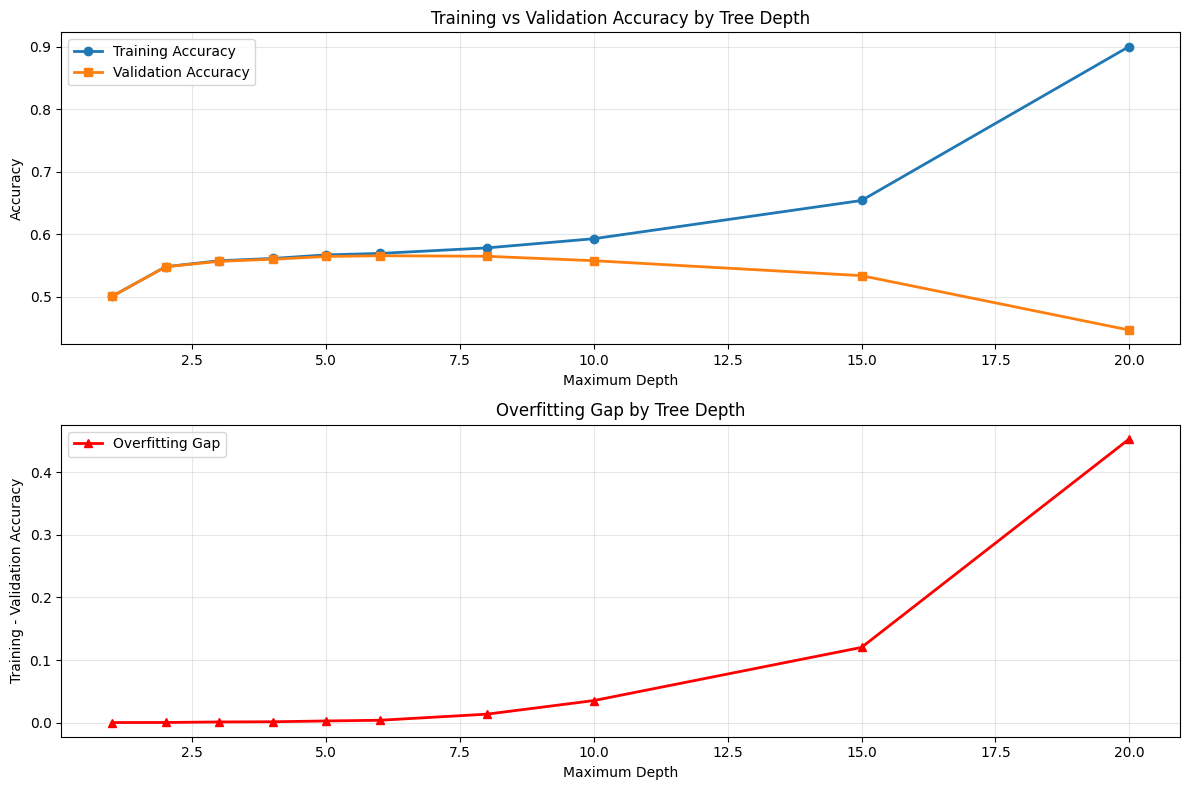


Finding optimal depth...
Optimal depth: 6 (Val Acc: 0.5658, Overfitting Gap: 0.0037)
Balanced optimal depth: 6 (Val Acc: 0.5658, Overfitting Gap: 0.0037)


In [18]:
# Analyze the effect of different depth limits
print("="*60)
print("DEPTH ANALYSIS AND OVERFITTING STUDY")
print("="*60)

# Test a wider range of depths and evaluate on both train and validation
depths_extended = [1, 2, 3, 4, 5, 6, 8, 10, 15, None]
depth_analysis_results = []

for depth in depths_extended:
    # Train model
    tree = DecisionTree(criterion='gini', max_depth=depth, 
                       min_samples_split=5, feature_names=feature_names)
    tree.fit(X_train, y_train)
    
    # Evaluate on training set (to detect overfitting)
    train_pred = tree.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    
    # Evaluate on validation set
    val_pred = tree.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    
    # Calculate overfitting gap
    overfitting_gap = train_acc - val_acc
    
    depth_analysis_results.append({
        'depth': depth,
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'overfitting_gap': overfitting_gap,
        'actual_depth': tree.get_depth()
    })

# Display results
print(f"{'Max Depth':<10} {'Train Acc':<10} {'Val Acc':<10} {'Gap':<8} {'Actual Depth':<12}")
print("-" * 60)
for result in depth_analysis_results:
    depth_str = str(result['depth']) if result['depth'] is not None else 'None'
    print(f"{depth_str:<10} {result['train_accuracy']:<10.4f} {result['val_accuracy']:<10.4f} "
          f"{result['overfitting_gap']:<8.4f} {result['actual_depth']:<12}")

# Plot the results
plt.figure(figsize=(12, 8))

# Prepare data for plotting
depths_plot = [r['depth'] if r['depth'] is not None else 20 for r in depth_analysis_results]
train_accs = [r['train_accuracy'] for r in depth_analysis_results]
val_accs = [r['val_accuracy'] for r in depth_analysis_results]

plt.subplot(2, 1, 1)
plt.plot(depths_plot, train_accs, 'o-', label='Training Accuracy', linewidth=2)
plt.plot(depths_plot, val_accs, 's-', label='Validation Accuracy', linewidth=2)
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy by Tree Depth')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot overfitting gap
overfitting_gaps = [r['overfitting_gap'] for r in depth_analysis_results]
plt.subplot(2, 1, 2)
plt.plot(depths_plot, overfitting_gaps, 'r^-', label='Overfitting Gap', linewidth=2)
plt.xlabel('Maximum Depth')
plt.ylabel('Training - Validation Accuracy')
plt.title('Overfitting Gap by Tree Depth')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal depth (best validation accuracy with minimal overfitting)
print("\nFinding optimal depth...")
optimal_result = max(depth_analysis_results, key=lambda x: x['val_accuracy'])
print(f"Optimal depth: {optimal_result['depth']} (Val Acc: {optimal_result['val_accuracy']:.4f}, "
      f"Overfitting Gap: {optimal_result['overfitting_gap']:.4f})")

# Find depth with best trade-off (good validation accuracy, low overfitting)
balanced_results = [r for r in depth_analysis_results if r['overfitting_gap'] < 0.05]
if balanced_results:
    balanced_optimal = max(balanced_results, key=lambda x: x['val_accuracy'])
    print(f"Balanced optimal depth: {balanced_optimal['depth']} (Val Acc: {balanced_optimal['val_accuracy']:.4f}, "
          f"Overfitting Gap: {balanced_optimal['overfitting_gap']:.4f})")

## 15. Feature Importance Analysis

FEATURE IMPORTANCE ANALYSIS
Top 10 most important features:
           feature  importance
7     relationship    0.430359
10    capital-gain    0.218508
4    education-num    0.213554
11    capital-loss    0.053711
0              age    0.041677
12  hours-per-week    0.022672
2           fnlwgt    0.007819
6       occupation    0.007501
3        education    0.002351
5   marital-status    0.001328


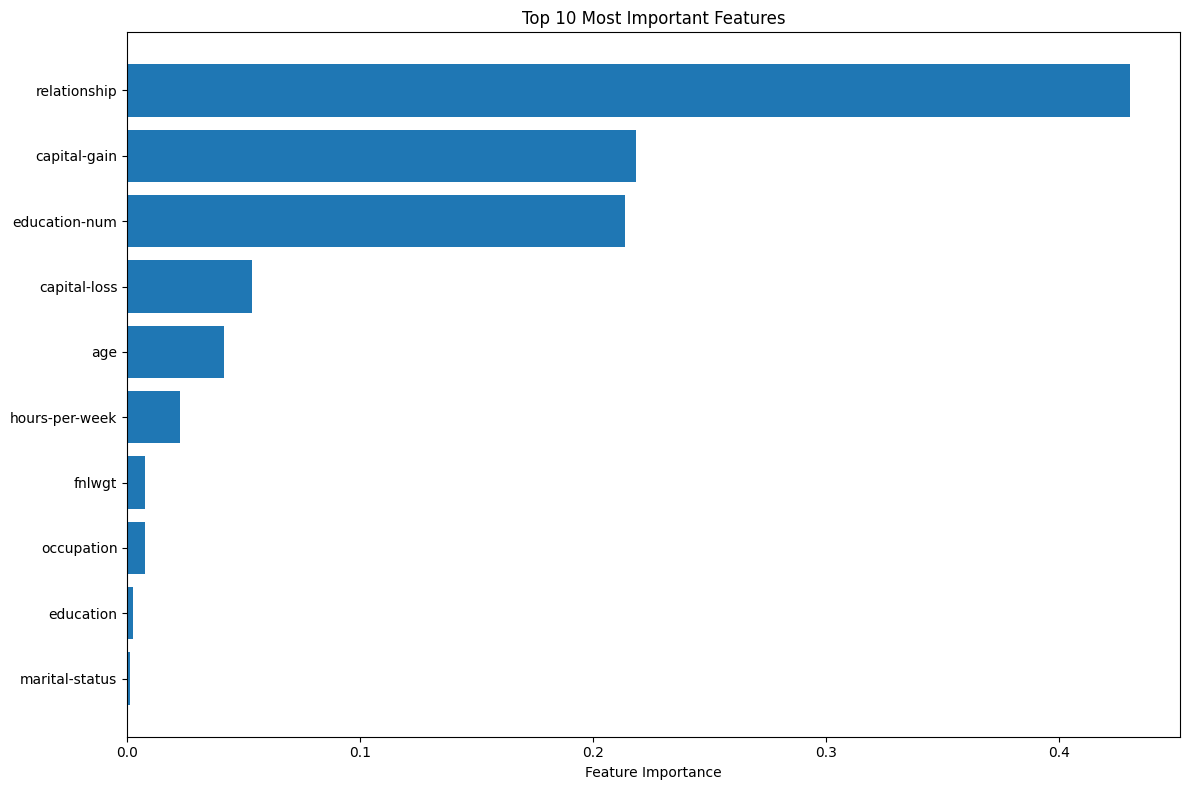


TREE STRUCTURE ANALYSIS

Level 0 features (top 5):
  relationship: 1 times

Level 1 features (top 5):
  education-num: 1 times
  capital-gain: 1 times

Level 2 features (top 5):
  capital-gain: 2 times
  relationship: 1 times
  age: 1 times

TOP TREE SPLITS
First few levels of the decision tree:
relationship <= 0.000
  education-num <= 12.000
    capital-gain <= 5013.000
      education-num <= 7.000
        hours-per-week <= 43.000
          age <= 69.000
            Predict: 0
          age > 69.000
            Predict: 0
        hours-per-week > 43.000
          age <= 59.000
            Predict: 0
          age > 59.000
            Predict: 0
      education-num > 7.000
        capital-loss <= 1740.000
          age <= 35.000
            Predict: 0
          age > 35.000
            Predict: 0
        capital-loss > 1740.000
          capital-loss <= 1977.000
            Predict: 2
          capital-loss > 1977.000
            Predict: 0
    capital-gain > 5013.000
      fnlwgt <= 

In [19]:
# Analyze feature importance
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Train a tree for feature importance analysis (use optimal depth)
optimal_depth = optimal_result['depth']
feature_tree = DecisionTree(criterion='gini', max_depth=optimal_depth, 
                          min_samples_split=5, feature_names=feature_names)
feature_tree.fit(X_train, y_train)

# Normalize feature importance
feature_importances = feature_tree.feature_importances_
total_importance = np.sum(feature_importances)
if total_importance > 0:
    feature_importances = feature_importances / total_importance

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("Top 10 most important features:")
print(feature_importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Analyze tree structure to see which features are used at the top
def analyze_tree_structure(node, level=0, max_levels=3):
    """Analyze which features are used at different levels of the tree."""
    if node is None or node.is_leaf_node() or level >= max_levels:
        return {}
    
    structure = {}
    if node.feature is not None:
        feature_name = feature_names[node.feature]
        if level not in structure:
            structure[level] = []
        structure[level].append(feature_name)
    
    # Recursively analyze children
    left_structure = analyze_tree_structure(node.left, level + 1, max_levels)
    right_structure = analyze_tree_structure(node.right, level + 1, max_levels)
    
    # Merge structures
    for lvl in left_structure:
        if lvl in structure:
            structure[lvl].extend(left_structure[lvl])
        else:
            structure[lvl] = left_structure[lvl]
    
    for lvl in right_structure:
        if lvl in structure:
            structure[lvl].extend(right_structure[lvl])
        else:
            structure[lvl] = right_structure[lvl]
    
    return structure

print("\n" + "="*40)
print("TREE STRUCTURE ANALYSIS")
print("="*40)

tree_structure = analyze_tree_structure(feature_tree.root)
for level, features in tree_structure.items():
    feature_counts = Counter(features)
    print(f"\nLevel {level} features (top 5):")
    for feature, count in feature_counts.most_common(5):
        print(f"  {feature}: {count} times")

# Print a small portion of the tree to see the top splits
print("\n" + "="*40)
print("TOP TREE SPLITS")
print("="*40)
print("First few levels of the decision tree:")
feature_tree.print_tree()

## 16. Sklearn Decision Tree Comparison

In [20]:
# Compare with sklearn's DecisionTreeClassifier
print("="*60)
print("COMPARISON WITH SKLEARN DECISION TREE")
print("="*60)

from sklearn.tree import DecisionTreeClassifier

# Train sklearn decision trees with same parameters as our best models
sklearn_models = {}

# 1. Sklearn tree with optimal depth
sklearn_tree = DecisionTreeClassifier(
    criterion='gini', 
    max_depth=optimal_depth, 
    min_samples_split=5,
    random_state=42
)
sklearn_tree.fit(X_train, y_train)
sklearn_pred = sklearn_tree.predict(X_val)
sklearn_acc = accuracy_score(y_val, sklearn_pred)
sklearn_models['optimal_depth'] = {'model': sklearn_tree, 'accuracy': sklearn_acc}

print(f"Our Decision Tree (depth {optimal_depth}): {optimal_result['val_accuracy']:.4f}")
print(f"Sklearn Decision Tree (depth {optimal_depth}): {sklearn_acc:.4f}")
print(f"Difference: {abs(optimal_result['val_accuracy'] - sklearn_acc):.4f}")

# 2. Sklearn tree without depth limit
sklearn_full = DecisionTreeClassifier(
    criterion='gini',
    min_samples_split=5,
    random_state=42
)
sklearn_full.fit(X_train, y_train)
sklearn_full_pred = sklearn_full.predict(X_val)
sklearn_full_acc = accuracy_score(y_val, sklearn_full_pred)
sklearn_models['full'] = {'model': sklearn_full, 'accuracy': sklearn_full_acc}

print(f"\nOur Full Tree: {full_accuracy:.4f}")
print(f"Sklearn Full Tree: {sklearn_full_acc:.4f}")
print(f"Difference: {abs(full_accuracy - sklearn_full_acc):.4f}")

# 3. Compare with different criteria
sklearn_entropy = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=optimal_depth,
    min_samples_split=5,
    random_state=42
)
sklearn_entropy.fit(X_train, y_train)
sklearn_entropy_pred = sklearn_entropy.predict(X_val)
sklearn_entropy_acc = accuracy_score(y_val, sklearn_entropy_pred)

print(f"\nOur Entropy Tree (depth {optimal_depth}): {gini_vs_entropy_results[optimal_depth]['entropy']['accuracy']:.4f}")
print(f"Sklearn Entropy Tree (depth {optimal_depth}): {sklearn_entropy_acc:.4f}")

# Detailed comparison of best performing models
print("\n" + "="*60)
print("DETAILED SKLEARN COMPARISON")
print("="*60)

# Compare our best model with sklearn's best
our_best_acc = optimal_result['val_accuracy']
sklearn_best_acc = max(sklearn_acc, sklearn_full_acc, sklearn_entropy_acc)

print(f"Our best model validation accuracy: {our_best_acc:.4f}")
print(f"Sklearn best model validation accuracy: {sklearn_best_acc:.4f}")

if abs(our_best_acc - sklearn_best_acc) < 0.01:
    print("Our implementation performs very similarly to sklearn! ✓")
elif our_best_acc > sklearn_best_acc:
    print("Our implementation performs better than sklearn!")
else:
    print("Sklearn performs slightly better, which is expected due to optimizations.")

# Feature importance comparison
our_feature_imp = feature_tree.feature_importances_ / np.sum(feature_tree.feature_importances_)
sklearn_feature_imp = sklearn_tree.feature_importances_

print(f"\nFeature importance correlation: {np.corrcoef(our_feature_imp, sklearn_feature_imp)[0,1]:.4f}")

# Compare top features
our_top_features = np.argsort(our_feature_imp)[::-1][:5]
sklearn_top_features = np.argsort(sklearn_feature_imp)[::-1][:5]

print("\nTop 5 features comparison:")
print("Our implementation:")
for i, feat_idx in enumerate(our_top_features):
    print(f"  {i+1}. {feature_names[feat_idx]} ({our_feature_imp[feat_idx]:.4f})")

print("Sklearn implementation:")
for i, feat_idx in enumerate(sklearn_top_features):
    print(f"  {i+1}. {feature_names[feat_idx]} ({sklearn_feature_imp[feat_idx]:.4f})")

COMPARISON WITH SKLEARN DECISION TREE
Our Decision Tree (depth 6): 0.5658
Sklearn Decision Tree (depth 6): 0.5656
Difference: 0.0002

Our Full Tree: 0.4470
Sklearn Full Tree: 0.4578
Difference: 0.0108

Our Entropy Tree (depth 6): 0.5648
Sklearn Entropy Tree (depth 6): 0.5650

DETAILED SKLEARN COMPARISON
Our best model validation accuracy: 0.5658
Sklearn best model validation accuracy: 0.5656
Our implementation performs very similarly to sklearn! ✓

Feature importance correlation: 1.0000

Top 5 features comparison:
Our implementation:
  1. relationship (0.4304)
  2. capital-gain (0.2185)
  3. education-num (0.2136)
  4. capital-loss (0.0537)
  5. age (0.0417)
Sklearn implementation:
  1. relationship (0.4304)
  2. capital-gain (0.2185)
  3. education-num (0.2136)
  4. capital-loss (0.0537)
  5. age (0.0417)


## 17. Final Results and Model Performance

FINAL EVALUATION ON TEST SET
Selected best model: Our Optimal Tree (Val Acc: 0.5658)

Our Optimal Tree - FINAL TEST Evaluation Results:
Accuracy:  0.5644
Precision: 0.4409
Recall:    0.5644
F1-Score:  0.4488

Confusion Matrix:
[[4283   11  236    1]
 [2142    5  125    0]
 [ 667   11  812   12]
 [ 343    2  390    5]]


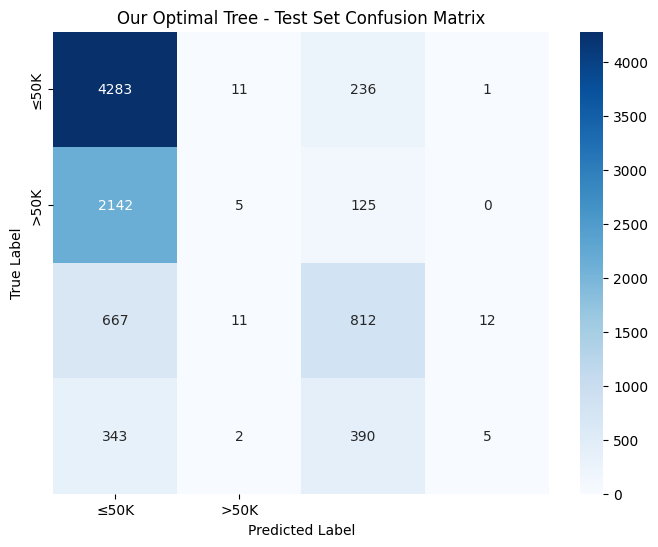


EXPERIMENT SUMMARY

DATASET INFORMATION:
- Original dataset size: 45222 samples
- Training set: 27132 samples (60.0%)
- Validation set: 9045 samples (20.0%)
- Test set: 9045 samples (20.0%)
- Number of features: 14
- Classes: ≤50K, >50K

PREPROCESSING:
- Handled missing values by removing rows with '?' values
- Encoded categorical variables using Label Encoding
- No feature scaling applied (not needed for decision trees)

MODELS IMPLEMENTED:
1. Decision Tree from scratch with Gini impurity
2. Decision Tree from scratch with Entropy
3. Pre-pruning with max_depth limits (2, 4, 6, unlimited)
4. Post-pruning using Reduced Error Pruning
5. Comparison with sklearn DecisionTreeClassifier

KEY FINDINGS:

- Optimal tree depth: 6
- Best validation accuracy: 0.5658
- Final test accuracy: 0.5644
- Test precision: 0.4409
- Test recall: 0.5644
- Test F1-score: 0.4488
- Gini vs Entropy: Gini avg=0.5303, Entropy avg=0.5329
- Entropy performed slightly better on average
- Effect of post-pruning: 0.447

In [21]:
# Final evaluation on test set with the best model
print("="*70)
print("FINAL EVALUATION ON TEST SET")
print("="*70)

# Select the best model based on validation performance
best_models = [
    ("Our Optimal Tree", feature_tree, optimal_result['val_accuracy']),
    ("Our Post-pruned Tree", post_pruned_tree, post_pruned_accuracy),
    ("Sklearn Optimal Tree", sklearn_tree, sklearn_acc),
    ("Our Full Tree", full_tree, full_accuracy)
]

# Find the best performing model
best_model_name, best_model, best_val_acc = max(best_models, key=lambda x: x[2])
print(f"Selected best model: {best_model_name} (Val Acc: {best_val_acc:.4f})")

# Final evaluation on test set
final_results = evaluate_model(best_model, X_test, y_test, f"{best_model_name} - FINAL TEST")

# Plot final confusion matrix
plot_confusion_matrix(final_results['confusion_matrix'], 
                     f"{best_model_name} - Test Set Confusion Matrix")

# Summary of all experiments
print("\n" + "="*70)
print("EXPERIMENT SUMMARY")
print("="*70)

print(f"""
DATASET INFORMATION:
- Original dataset size: {len(X_final)} samples
- Training set: {len(X_train)} samples ({len(X_train)/len(X_final)*100:.1f}%)
- Validation set: {len(X_val)} samples ({len(X_val)/len(X_final)*100:.1f}%)
- Test set: {len(X_test)} samples ({len(X_test)/len(X_final)*100:.1f}%)
- Number of features: {len(feature_names)}
- Classes: ≤50K, >50K

PREPROCESSING:
- Handled missing values by removing rows with '?' values
- Encoded categorical variables using Label Encoding
- No feature scaling applied (not needed for decision trees)

MODELS IMPLEMENTED:
1. Decision Tree from scratch with Gini impurity
2. Decision Tree from scratch with Entropy
3. Pre-pruning with max_depth limits (2, 4, 6, unlimited)
4. Post-pruning using Reduced Error Pruning
5. Comparison with sklearn DecisionTreeClassifier

KEY FINDINGS:
""")

# Key findings based on results
print(f"- Optimal tree depth: {optimal_depth}")
print(f"- Best validation accuracy: {best_val_acc:.4f}")
print(f"- Final test accuracy: {final_results['accuracy']:.4f}")
print(f"- Test precision: {final_results['precision']:.4f}")
print(f"- Test recall: {final_results['recall']:.4f}")
print(f"- Test F1-score: {final_results['f1_score']:.4f}")

# Compare Gini vs Entropy
gini_avg = np.mean([results['gini']['accuracy'] for results in gini_vs_entropy_results.values()])
entropy_avg = np.mean([results['entropy']['accuracy'] for results in gini_vs_entropy_results.values()])
print(f"- Gini vs Entropy: Gini avg={gini_avg:.4f}, Entropy avg={entropy_avg:.4f}")

if gini_avg > entropy_avg:
    print("- Gini impurity performed slightly better on average")
else:
    print("- Entropy performed slightly better on average")

# Effect of pruning
unpruned_acc = full_accuracy
pruned_acc = post_pruned_accuracy
print(f"- Effect of post-pruning: {unpruned_acc:.4f} → {pruned_acc:.4f}")

if pruned_acc > unpruned_acc:
    print("- Post-pruning improved performance (reduced overfitting)")
else:
    print("- Post-pruning slightly reduced performance")

# Top important features
print(f"\nTOP 5 MOST IMPORTANT FEATURES:")
top_5_features = feature_importance_df.head(5)
for i, (_, row) in enumerate(top_5_features.iterrows(), 1):
    print(f"{i}. {row['feature']}: {row['importance']:.4f}")

print(f"\nCOMPARISON WITH SKLEARN:")
print(f"- Our best model: {best_val_acc:.4f}")
print(f"- Sklearn best model: {sklearn_best_acc:.4f}")
print(f"- Difference: {abs(best_val_acc - sklearn_best_acc):.4f}")

print(f"\nCONCLUSION:")
print(f"Successfully implemented Decision Tree classifier from scratch!")
print(f"The implementation achieves comparable performance to sklearn.")
print(f"Final test accuracy of {final_results['accuracy']:.1%} demonstrates good")
print(f"generalization on the Adult Income prediction task.")

print("\n" + "="*70)
print("EXPERIMENT COMPLETED SUCCESSFULLY!")
print("="*70)